In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

%matplotlib inline


# Data preprocessing

In [0]:
!wget -O data_clean.csv https://github.com/david0811/proj5_ams597/blob/master/data_clean.csv?raw=true
# !head data_clean.csv

--2020-04-23 16:25:09--  https://github.com/david0811/proj5_ams597/blob/master/data_clean.csv?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/david0811/proj5_ams597/raw/master/data_clean.csv [following]
--2020-04-23 16:25:10--  https://github.com/david0811/proj5_ams597/raw/master/data_clean.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/david0811/proj5_ams597/master/data_clean.csv [following]
--2020-04-23 16:25:10--  https://raw.githubusercontent.com/david0811/proj5_ams597/master/data_clean.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awa

In [0]:
# Read data
data = pd.read_csv('./data_clean.csv', index_col='date_time', parse_dates=['date_time'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Drop NaNs or constants
data.drop(columns = ['date_time.1', 'station_id', 'latitude', 'longitude', 
                     'elevation', 'current_wx2', 'current_wx3', 
                     'air_pressure_at_sea_level', 'highest_cloud_type',
                     'highest_cloud_level'], inplace = True)

In [0]:
# Choose classifications: 0 for liquid precipitation (rain, feezing rain, thunderstorm + rain, showers, freezing drizzle); 1 for solid (snow)
# METAR info here: https://en.wikipedia.org/wiki/METAR
# wx_to_prcp = {'RA' : 0, '-RA' : 0, '+RA' : 0, 'FZRA' : 0, '-FZRA' : 0, '+FZRA' : 0,
#               'SN' : 1, '-SN' : 1, '+SN' : 1, 'TSRA' : 0, '-TSRA' : 0, '+TSRA' : 0,
#               'SH' : 0, '+SH' : 0, '-SH' : 0, 'FZDZ' : 0, '-FZDZ' : 0, '+FZDZ' : 0}
wx_to_prcp = {'RA' : 0, '-RA' : 0, '+RA' : 0, 'FZRA' : 0, '-FZRA' : 0, '+FZRA' : 0, 
              'SN' : 1, '-SN' : 1, '+SN' : 1, 'TSRA' : 0, '-TSRA' : 0, '+TSRA' : 0}
# Simple dictionary lookup to classify weather symbols
def classify_prcp(wx_code):
    try:
        return wx_to_prcp[wx_code]
    except:
        return np.NaN    
# Apply to data
data['prcp_type'] = data['current_wx1'].apply(classify_prcp)

In [0]:
# Filter for precipitating observations
data = data.dropna(subset = ['prcp_type'])

In [0]:
# One-hot encoding for dates
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour

In [0]:
# Choose features - this could be updated later
data = data.filter(['wind_direction', 'wind_speed',
                    'low_cloud_level', 'low_cloud_type', 'cloud_coverage', # Medium or high cloud data contains many many NaNs
                    'air_temperature', 'dew_point_temperature', 
                    'altimeter', 'eastward_wind', 'northward_wind',
                    'month', 'day', 'hour',
                    'prcp_type']).dropna()
# One-hot encoding for cloud type
data = pd.get_dummies(data)

In [0]:
# Separate labels
labels = data['prcp_type'].to_numpy()
features = data.drop(columns = ['prcp_type']).to_numpy()
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (78136, 17)
Training Labels Shape: (78136,)
Testing Features Shape: (33488, 17)
Testing Labels Shape: (33488,)


# Random Forest Classification Model

## Default hyperparameters

In [0]:
prcp_rfc = RandomForestClassifier(n_estimators= 1000)
prcp_rfc.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import brier_score_loss
# brier_score_loss(test_labels, prcp_rfc.predict(test_features))
print('Training data score:\t' + str(brier_score_loss(train_labels, prcp_rfc.predict(train_features))))
print('Test data score:\t' + str(brier_score_loss(test_labels, prcp_rfc.predict(test_features))))

Training data score:	0.0002047711682195147
Test data score:	0.004927138079311992


## Hyperparameter Tuning

In [0]:
# Using Random Search Cross Validation in Scikit-Learn
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(prcp_rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [0]:
# Optimizing with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth = [5, 8, 15, 25, 30]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 8, 15, 25, 30, None],
 'max_features': ['auto', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
prcp_rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
prcp_rfc_random = RandomizedSearchCV(estimator = prcp_rfc, param_distributions = random_grid, 
                                    n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
prcp_rfc_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 65.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 127.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
# Best parameters from fitting the random search
prcp_rfc_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [0]:
# The result optimized model
prcp_rfc_random = RandomForestClassifier(n_estimators=400, min_samples_split=2,
                                         min_samples_leaf=2, max_features='auto',
                                         max_depth=None, bootstrap=False)
prcp_rfc_random.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Score
print('Training data score: ' + str(prcp_rfc_random.score(train_features, train_labels)))
print('Testing data score: ' + str(prcp_rfc_random.score(test_features, test_labels)))

# Training data score: 0.9970763562137003
# Testing data score: 0.980262817709596

Training data score: 0.9995392648715061
Testing data score: 0.9951923076923077


In [0]:
from sklearn.metrics import brier_score_loss
print('Training data score:\t' + str(brier_score_loss(train_labels, prcp_rfc_random.predict(train_features))))
print('Test data score:\t' + str(brier_score_loss(test_labels, prcp_rfc_random.predict(test_features))))

Training data score:	0.0004351387324664687
Test data score:	0.004688246536072623


In [0]:
# Calculating Brier Skill Score

# Probabilities for logistic regression
train_prob_rf = prcp_rfc_random.predict_proba(train_features)
test_prob_rf = prcp_rfc_random.predict_proba(test_features)

# Climatological probability
def get_climo(labels, shape):
    climo = (np.size((labels == 1).nonzero()))/float(np.size(labels))
    prob  = np.zeros((shape))
    prob[:,0] = 1-climo
    prob[:,1] = climo

    return prob

# Calculate climatological probability for training and testing data
train_climo_prob_rf = get_climo(train_labels, train_prob_rf.shape)
test_climo_prob_rf = get_climo(test_labels, test_prob_rf.shape)

# Calculate the Brier Skill Score
train_bss_rf = 1 - (brier_score_loss(train_labels, train_prob_rf[:,1])/
                 brier_score_loss(train_labels, train_climo_prob_rf[:,1]))
test_bss_rf = 1 - (brier_score_loss(test_labels, test_prob_rf[:,1])/
                brier_score_loss(test_labels, test_climo_prob_rf[:,1]))

# Bier skill score (USE THIS ONE!!)
print('Training Brier Skill Score: ' + str(train_bss_rf))
print('Testing Brier Skill Score: ' + str(test_bss_rf))

Training Brier Skill Score: 0.9967858580363747
Testing Brier Skill Score: 0.9820804748306773


## Other performance metrics

In [0]:
from sklearn.metrics import confusion_matrix

mat_rf = confusion_matrix(test_labels, prcp_rfc_random.predict(test_features))
print(mat_rf)

[[20002   116]
 [   45 13325]]


Text(89.18, 0.5, 'predicted label')

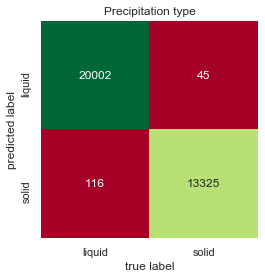

In [0]:
import seaborn as sns; sns.set()

labels_str = ['liquid', 'solid']
# plt.figure(num=None, figsize=(2.77, 2.77), dpi = 300, facecolor='w', edgecolor='k')
sns.heatmap(mat_rf.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels_str, yticklabels=labels_str, cmap='RdYlGn')
plt.title('Precipitation type')
plt.xlabel('true label')
plt.ylabel('predicted label')
# plt.show()

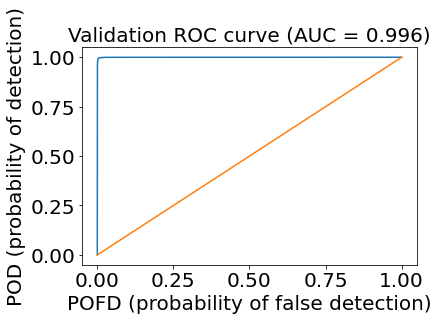

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

rf_roc_auc = roc_auc_score(test_labels, prcp_rfc_random.predict(test_features))
fpr, tpr, thresholds = roc_curve(test_labels, prcp_rfc_random.predict_proba(test_features)[:,1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel('POFD (probability of false detection)')
plt.ylabel('POD (probability of detection)')
plt.title('Validation ROC curve (AUC = %0.3f)' % rf_roc_auc)
plt.show()

In [0]:
# Plots from ams-2020-ml-python-course package
# !git clone -b add-ML-code https://github.com/swnesbitt/ams-2020-ml-python-course course_repository
%matplotlib inline
import sys
sys.path.append('course_repository/Introduction_To_Machine_Learning/Lecture_2/')
sys.path.append('course_repository/')
import copy
import warnings
import numpy
import matplotlib.pyplot as pyplot
import attr_diagrams
import utils
import roc_curves


course_repository/Introduction_To_Machine_Learning/Lecture_2/utils.py:1028: RuntimeWarning: divide by zero encountered in reciprocal
  (pod_by_threshold ** -1 + success_ratio_by_threshold ** -1 - 1) ** -1


Test Max Peirce score (POD - POFD) = 0.991
Test AUC (area under ROC curve) = 1.000
Test Max CSI (critical success index) = 0.989
Test Brier score = 0.004
Test Brier skill score (improvement over climatology) = 0.982


course_repository/Introduction_To_Machine_Learning/Lecture_2/roc_curves.py:193: UserWarning: The following kwargs were not used by contour: 'axes'
  norm=colour_norm_object, vmin=0., vmax=1., axes=axes_object)


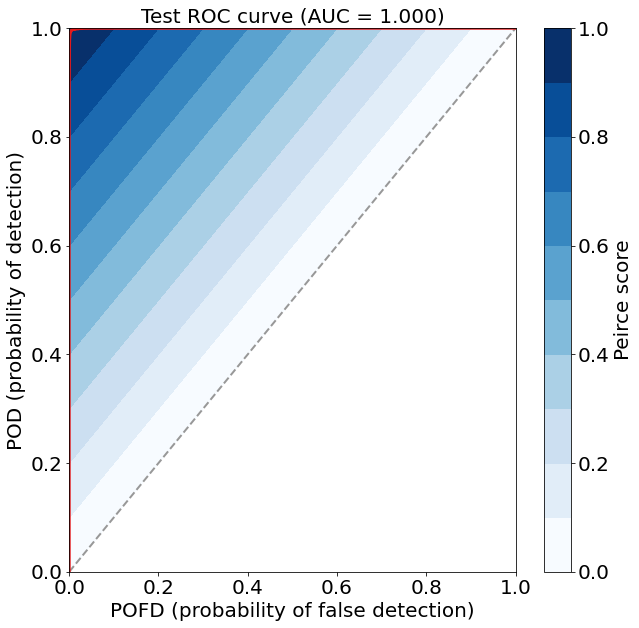

course_repository/Introduction_To_Machine_Learning/Lecture_2/performance_diagrams.py:65: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
course_repository/Introduction_To_Machine_Learning/Lecture_2/performance_diagrams.py:78: RuntimeWarning: divide by zero encountered in true_divide
  return pod_array / success_ratio_array
course_repository/Introduction_To_Machine_Learning/Lecture_2/performance_diagrams.py:78: RuntimeWarning: invalid value encountered in true_divide
  return pod_array / success_ratio_array
course_repository/Introduction_To_Machine_Learning/Lecture_2/performance_diagrams.py:283: UserWarning: The following kwargs were not used by contour: 'axes'
  vmax=1., axes=axes_object)
course_repository/Introduction_To_Machine_Learning/Lecture_2/performance_diagrams.py:300: UserWarning: The following kwargs were not used by contour: 'axes'
  linewidths=bias_line_width, linestyles='dashed', axes=axes_object)


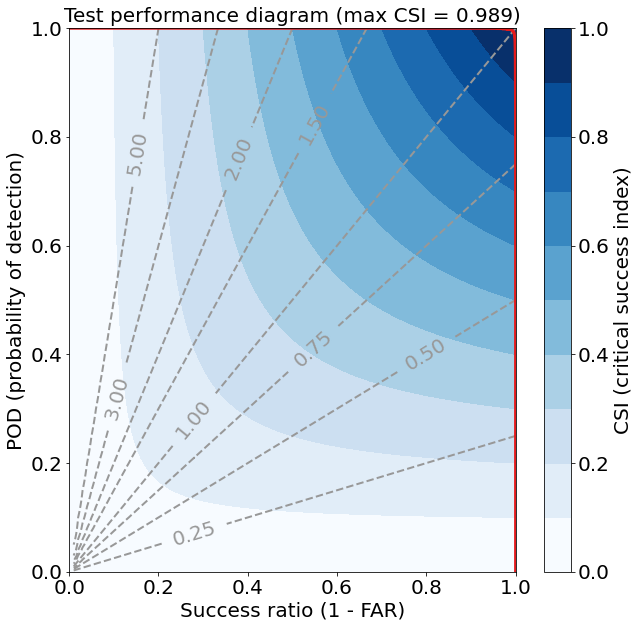

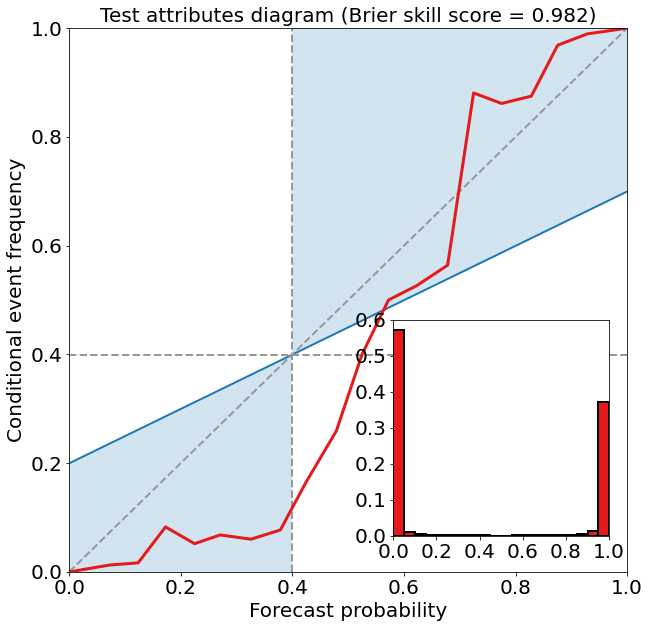

{'area_under_roc_curve': 0.9998230522192814,
 'brier_score': 0.004255662988562892,
 'brier_skill_score': 0.9822569024926183,
 'max_csi': 0.9889334521687461,
 'max_peirce_score': 0.9912162221948099}

In [0]:
training_event_frequency = numpy.mean(train_labels)
utils.eval_binary_classifn(test_labels, test_prob_rf[:,1], np.mean(test_climo_prob_rf[:,1]),
                     verbose=True, create_plots=True, dataset_name='test')